In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../notebooks_publications/')
import bluranalysis as analysis

# plt.style.use('deblur')

# DNF and SNR Bounds

For any illumination sequence with exactly $N$ pulses (or more generally, with total illumination $\sum_{i=1}^n v_i = N)$, we will have (assuming the illumination power of a single pulse is normalized to $1$) a signal-to-noise ratio (SNR) of
$$SNR = \frac{\bar{i}_0 N}{f \sqrt{\sigma_{\text{gray}}^2 + \sigma_d^2 N}}\:,$$
where $\bar{i}_0$ is the average intensity of the object, $\sigma_{\text{gray}}$ is the signal-independent part of the noise, and $\sigma_d$ is the weight on the signal-dependent part of the noise. We define the (normalized) deconvolution noise factor (DNF) $f$ as
$$f = \sqrt{\frac{1}{m} \sum_{i=1}^m \frac{\sigma_1^2}{\sigma_i^2}}\:,$$
where $\sigma_1,...,\sigma_m$ are the ordered singular values of the blur operation $A$. Since $A$ is a convolutional operator with kernel $b=\sum_{j=1}^n v_j \delta_j$, the singular values are given by the power spectrum $\{|(Fb)_i|^2\}_{i=1}^m$. The $v_i$ are illumination values and the $\delta_i$ are the positions.

In this notebook, I discuss

1. a *lower bound* on the DNF, which translates to an *upper bound* on the SNR, i.e. the *best* we could ever do.
2. an *upper bound* on the DNF, which translates into a *lower bound* on the SNR, i.e. the *worst* we can expect to do. This is somewhat less important to our story.

# Lower and Upper Bounds on DNF

Lemma: We have the bounds 
$$ \frac{m-1}{m} + \frac{1}{m}\frac{N^2}{\sigma_m^2}\leq f^2 \leq \frac{1}{m} + \frac{m-1}{m}\frac{N^2}{\sigma_m^2}\:.$$

*Proof*: Starting with $f^2 = \frac{1}{m} \sum_{i=1}^m \frac{\sigma_1^2}{\sigma_i^2}$, note that $\frac{\sigma_1^2}{\sigma_i^2} \geq 1$ for all $i$. Plugging in this bound for $i=1,...,m-1$, we see that
$$f^2 \geq \frac{1}{m} \cdot (m-1) + \frac{1}{m}\frac{\sigma_1^2}{\sigma_m^2}\:.$$
Then the result follows by the observation that $\sigma_1$ is the DC component of the signal, which is $\sum_{i=1}^n v_i = N$.

 Similar to the lower bound, note that $\frac{\sigma_1^2}{\sigma_i^2} \leq \frac{\sigma_1^2}{\sigma_m^2}$ for all $i$. Plugging in this bound for $i=2,...,m$, we see that
$$f^2 \leq \frac{1}{m} + \frac{1}{m}\frac{N^2}{\sigma_m^2}\cdot (m-1)\:,$$
where we again use that $\sigma_1$ is the DC component of the signal.


../notebooks_publications/bluranalysis.py:110: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(1 / len(x) * np.sum(np.max(sigma_x) / sigma_x))
../notebooks_publications/bluranalysis.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  values_upper.append( np.sqrt(1/m  + calcMaxSingFromKernel(kernel)**2 * (m-1) / m * 1 / calcMinSingFromKernel(kernel)**2 ))
../notebooks_publications/bluranalysis.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  values_lower.append( np.sqrt((m-1) / m + calcMaxSingFromKernel(kernel)**2 * 1 / m * 1 / calcMinSingFromKernel(kernel)**2 ))


<IPython.core.display.Javascript object>


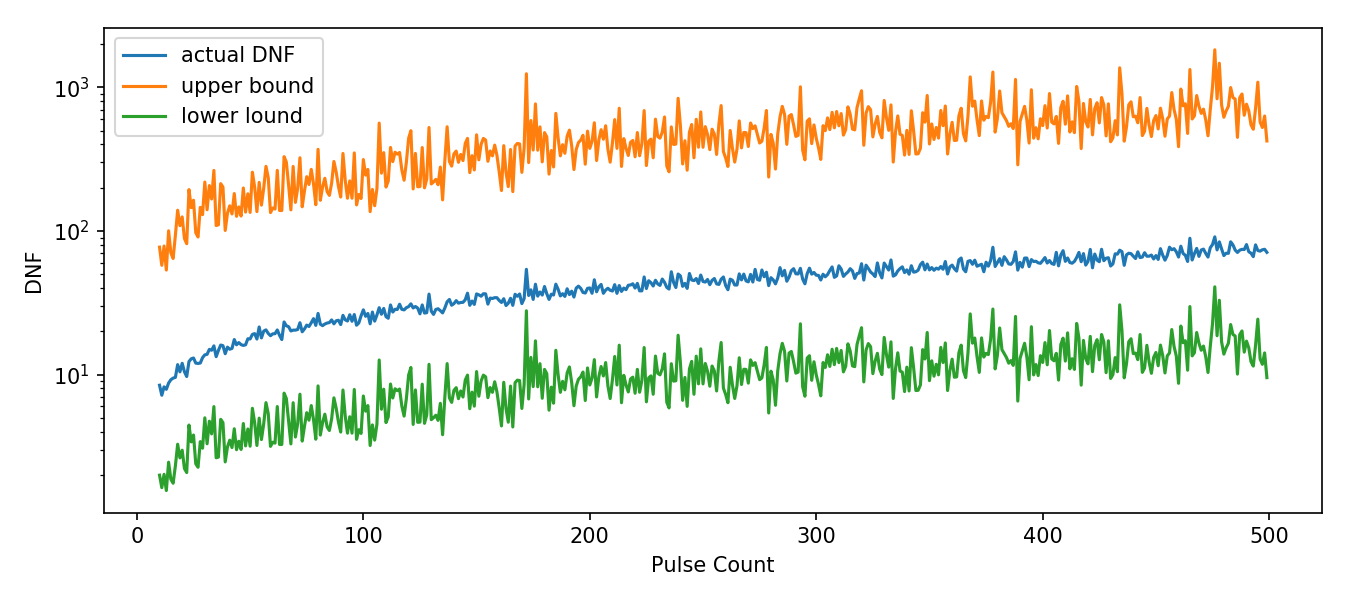

In [4]:
# Numerical Validation of Bounds

kernel_size = 1000 
pulse_count_list = np.arange(10,500)

dnf_list = []; 
dnf_upper_list = []; dnf_lower_list = []
for pulse_count in pulse_count_list:
    res = analysis.getOptimalDnf(kernel_size, n_pulses=pulse_count, n_tests=5, 
                                           padding_size=kernel_size, generation='randomchoice',
                                          metric='dnf', returnall=True)
    dnf_list.append(res[0]); 
    dnf_upper_list.append(res[4]); dnf_lower_list.append(res[5])

plt.figure(figsize=(9,4))
plt.semilogy(pulse_count_list, np.array(dnf_list), label='actual DNF')
plt.semilogy(pulse_count_list, np.array(dnf_upper_list), label='upper bound')
plt.semilogy(pulse_count_list, np.array(dnf_lower_list), label='lower lound')

plt.xlabel('Pulse Count')
plt.ylabel('DNF')
plt.legend()
plt.tight_layout()

# Simplifying to Upper Bound on SNR (from Lower Bound on DNF)

Lemma: We have the following relationship between average squared singular value and illumination values, $\frac{1}{m}\sum_{i=1}^m \sigma_i^2 = \sum_{j=1}^n v_j^2$.

*Proof*: Since the singular values are given by the vector $Fb = F\sum_{j=1}^n v_j \delta_j$, the average squared singular values is given by the inner product
$$\frac{1}{m} \sum_{i=1}^m \sigma_i^2 = \frac{1}{m} (Fb)^H Fb =  \frac{1}{m} \sum_{j=1}^n \sum_{\ell=1}^n v_jv_\ell \delta_j^H F^H F\delta_\ell =  \frac{1}{m} \sum_{j=1}^n  v_j^2 $$
where the final simplification comes from noting that $F^H F = I$ and $\delta_j^H\delta_\ell = \mathbf{1}\{j=\ell\}$.

TODO: the above is has an extra factor of $\frac{1}{m}$, in contradiction with numerical validation below. Perhaps this is due to scaling on the Fourier transform, we should instead have $F^HF = mI$? (Note that $F$ is $m\times m$.)

In [5]:
# A numerical validation of the above lemma

def check_equiv(n_pulses, kernel_length, padding_size=0, generation='binary'):
    kernel = np.zeros(kernel_length+padding_size)
    if generation == 'binary':
        indicies = np.random.choice(kernel_length, size=n_pulses, replace=False)
        kernel[indicies] = 1.0
    else:
        kernel[0:kernel_length] = np.random.uniform(0,1, size=kernel_length)
    
    x_fft = np.fft.fft(kernel)
    sigma_x = np.abs(x_fft)**2
    return np.abs(np.sum(kernel**2)-np.mean(sigma_x))

for n_pulses in range(10,100):
    kernel_length = 200; padding_size = kernel_length
    assert check_equiv(n_pulses, kernel_length, padding_size, 'binary') < 1e-10
    assert check_equiv(n_pulses, kernel_length, padding_size, 'uniform') < 1e-10
    
print("All assertions passed")

All assertions passed


### Upper Bound on SNR
Proposition: For any fixed $N$, the best achievable SNR is
$$SNR \leq \frac{\bar{i}_0 \sqrt{N}}{C \sqrt{\sigma_{\text{gray}}^2 + \sigma_d^2 N}}\:,$$
where $C$ is a constant that depends on the overall length of the blur kernel.

*Proof*: First, note that since $\sigma_m^2 = \min_i \sigma_i^2 \leq \frac{1}{m}\sum_{i=1}^m \sigma_i$, we have that (using first the lower bound Lemma and then the other Lemma),
$$f^2 \geq \frac{m-1}{m} + \frac{1}{m}\frac{N^2}{\frac{1}{m}\sum_{i=1}^m\sigma_i^2} = \frac{m-1}{m} + \frac{1}{m}\frac{N^2}{\sum_{j=1}^nv_j^2} \geq  \frac{m-1}{m} + \frac{1}{m} N$$
notice the fact that
$$\max_{v\in[0,1]^n} \sum_{j=1}^nv_j^2~:~ \sum_{j=1}^n v_j=N$$
is achieved for binary $v$ and has the maximum value $N$. Then we can upper bound $\frac{m-1}{m} + \frac{1}{m} N\geq \frac{3m-1}{m^2} N$ for example, if we assure that $N\leq \frac{m}{2}$. Thus, letting $C=\frac{\sqrt{3m-1}}{m}$ , we have that $f\geq C\sqrt{N}$. Plugging this into the definition of SNR gives the result.
 

### Importance of $\sigma_\text{gray}$

Note that from the above proposition, if $\sigma_{\text{gray}}^2\ll \sigma_d^2 $, the SNR does not increase with $N$ -- in fact, it can only stay the same or decrease.


# Thoughts on Lower Bound on SNR

To make any interesting SNR lower bound statement, we need to have an upper bound on $ \frac{1}{m} + \frac{m-1}{m}\frac{N^2}{\sigma_m^2}$, which requires a lower bound on $\sigma_m^2$ for fixed $N$. Of course, one lower bound would be zero, but this gives a vacuous result.

If we could show that $\sigma_m^2\geq c$ for some constant $c$ that does not grow with $N$, we could show that $f\leq CN$ (for some $C$), which would mean  $SNR \geq \frac{\bar{i}_0 }{C \sqrt{\sigma_{\text{gray}}^2 + \sigma_d^2 N}}$. This is not a particularly interesting result though.
